Benchmark of 4 feature selection techniques: HSIC Lasso, Block HSIC Lasso, mRMR and LARS. For each of the methods, the way to select features was different:

- mRMR and LARS are asked to select the best 4 features.
- (Baby) HSIC Lasso is asked to select 50 features. All 50 are used for the regression, but only the top 4 are considered for feature selection evaluation. Baby HSIC lasso instances run 3 permutations to reduce the estimator sampling error.

# Data simulated as in Yamada *et al.*

## Additive model

The outcome is generated as

$$y=2 sin(2 x_1) + x_2^2 + x_3 + exp(-x_4) + \varepsilon$$

where $\varepsilon ~ N(0,1)$. The script is available [here](../scripts/templates/analysis/yamada_additive.py).

In [74]:
library(tidyverse)
library(cowplot)

palette <- c('HSIC' = '#c994c7', 
#              'HSIC Lasso, B = 50' = '#df65b0',
#              'HSIC Lasso, B = 20' = '#e7298a', 'HSIC Lasso, B = 10' = '#ce1256',
#              'HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443',
#              'LoHSIC, L = 1, S = 1' = '#abaf1c',
#              'LoHSIC, L = 1, S = 10' = '#1bd145',
             'LoHSIC, L = 5, S = 1' = '#b70eb7'
#              'LoHSIC, L = 5, S = 10' = '#b5c61b'
            )
methods <- c('HSIC', 
#              'HSIC Lasso, B = 50',
#              'HSIC Lasso, B = 40','HSIC Lasso, B = 30',
#              'HSIC Lasso, B = 20','HSIC Lasso, B = 10',
#              'HSIC Lasso, B = 5', 
             'mRMR', 'LARS',
#              'LoHSIC, L = 1, S = 1',
#              'LoHSIC, L = 1, S = 10',
             'LoHSIC, L = 5, S = 1'
#              'LoHSIC, L = 5, S = 10'
             
            )
samples_ord <-  c('50 samples', '100 samples', '200 samples', '300 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')

prepare_df <- function(x) {
    mutate(x,
           model = gsub('HSIC_lasso', 'HSIC', model),
           model = gsub('-B=0', '', model),
           model = gsub('-B=', ', B = ', model),
           model = gsub('-M=3', '', model),
           model = gsub('localized_', 'Lo', model),
           model = gsub('-K=', ', L = ', model),
           model = gsub('-S=', ', S = ', model),
           model = factor(model, levels = methods),
           samples_txt = factor(paste(samples, 'samples'), levels=samples_ord),
           causal_txt = paste(causal, 'causal'),
           features_txt = factor(paste(features, 'features'), levels = feats)) %>%
    group_by(model, samples, features, causal, samples_txt, features_txt, causal_txt) 
}

In [75]:
# Feature selection measures
ya_features <- read_tsv('../results/others_benchmark/yamada_additive_feature_selection.tsv', 
                        col_types = 'ciiiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup %>%
    filter(! is.na(model))  %>%
    filter(samples_txt != '200 samples') %>%
    filter(samples_txt != '300 samples')
ya_features_lhsic <- read_tsv('../results/lhl_benchmark_additive_scale/yamada_additive_feature_selection.tsv', 
                        col_types = 'ciiiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup
ya_features_all <- bind_rows(ya_features, ya_features_lhsic)

# Regression measures
ya_prediction <- read_tsv('../results/others_benchmark/yamada_additive_prediction.tsv', 
                       col_types = 'ciiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(mse)),
              sem = sd(mse) / sqrt(ended), mse = mean(mse) ) %>%
    ungroup %>%
    filter(! is.na(model))
ya_prediction_lhsic <- read_tsv('../results/lhl_benchmark_additive_scale/yamada_additive_prediction_lhsic.tsv', 
                       col_types = 'ciiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(mse)),
              sem = sd(mse) / sqrt(ended), mse = mean(mse) ) %>%
    ungroup
ya_prediction_all <- bind_rows(ya_prediction, ya_prediction_lhsic)

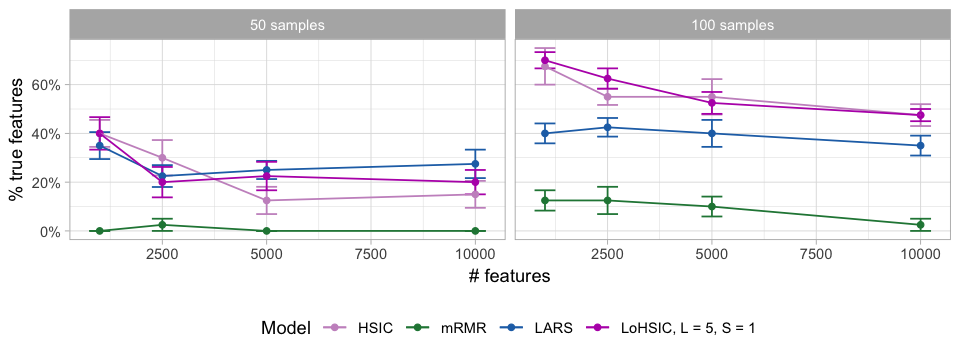

In [76]:
options(repr.plot.width=8, repr.plot.height=3.)
padd <- ggplot(ya_features_all, aes(x = features, y = tpr, color = model)) +
    geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 500) +
    geom_point() +
    geom_line() +
    theme_light() +
    theme(legend.position = 'bottom') +
    labs(x = '# features', y = '% true features', color = 'Model') +
    facet_grid(. ~ samples_txt) + 
    scale_y_continuous(labels = scales::percent) +
    scale_color_manual(values = palette)
padd
save_plot('./imgs/lhsic_additive.pdf', padd, base_height = 3.0, base_width = 6.0)

Warning message:
“Removed 8 rows containing missing values (geom_point).”Warning message:
“Removed 8 rows containing missing values (geom_path).”

Warning message:
“Removed 8 rows containing missing values (geom_point).”Warning message:
“Removed 8 rows containing missing values (geom_path).”

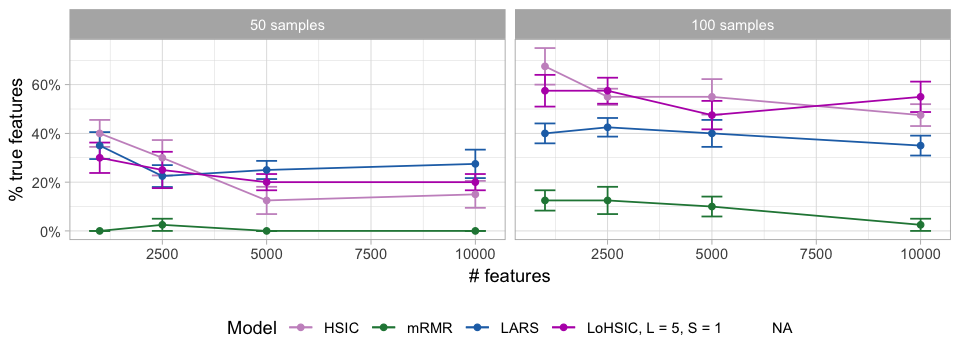

In [68]:
#old runs - before localonly
options(repr.plot.width=8, repr.plot.height=3.)
padd <- ggplot(ya_features_all, aes(x = features, y = tpr, color = model)) +
    geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 500) +
    geom_point() +
    geom_line() +
    theme_light() +
    theme(legend.position = 'bottom') +
    labs(x = '# features', y = '% true features', color = 'Model') +
    facet_grid(. ~ samples_txt) + 
    scale_y_continuous(labels = scales::percent) +
    scale_color_manual(values = palette)
padd
save_plot('./imgs/lhsic_additive.pdf', padd, base_height = 3.0, base_width = 6.0)

In [260]:
# options(repr.plot.width=10, repr.plot.height=4)
# ya_prediction_all %>%
# #     filter(model != 'Localized HSIC Lasso, L = 10') %>%
#     ggplot(aes(x = samples, y = mse, color = model)) +
#         geom_errorbar(aes(ymin = mse - sem, ymax = mse + sem), width = 500) +
#         geom_point() +
#         geom_line() +
#         theme_linedraw() +
#         theme(legend.position = 'bottom') +
#         labs(x = '# samples', y = 'MSE', color = 'Model') +
#         facet_grid(. ~ features_txt) +
#         scale_color_manual(values = palette)

In [58]:
# ya_features_all

# additive + 2noise

In [56]:
library(tidyverse)
library(cowplot)

palette <- c('HSIC' = '#c994c7', 
#              'HSIC Lasso, B = 50' = '#df65b0',
#              'HSIC Lasso, B = 20' = '#e7298a', 'HSIC Lasso, B = 10' = '#ce1256',
#              'HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443',
             'LoHSIC, L = 1, S = 1' = '#abaf1c',
#              'LoHSIC, L = 1, S = 10' = '#1bd145',
             'LoHSIC, L = 5, S = 1' = '#b70eb7'
#              'LoHSIC, L = 5, S = 10' = '#b5c61b'
            )
methods <- c('HSIC', 
#              'HSIC Lasso, B = 50',
#              'HSIC Lasso, B = 40','HSIC Lasso, B = 30',
#              'HSIC Lasso, B = 20','HSIC Lasso, B = 10',
#              'HSIC Lasso, B = 5', 
             'mRMR', 'LARS',
             'LoHSIC, L = 1, S = 1',
#              'LoHSIC, L = 1, S = 10',
             'LoHSIC, L = 5, S = 1'
#              'LoHSIC, L = 5, S = 10'
             
            )
samples_ord <-  c('50 samples', '100 samples', '200 samples', '300 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')

prepare_df <- function(x) {
    mutate(x,
           model = gsub('HSIC_lasso', 'HSIC', model),
           model = gsub('-B=0', '', model),
           model = gsub('-B=', ', B = ', model),
           model = gsub('-M=3', '', model),
           model = gsub('localized_', 'Lo', model),
           model = gsub('-K=', ', L = ', model),
           model = gsub('-S=', ', S = ', model),
           model = factor(model, levels = methods),
           samples_txt = factor(paste(samples, 'samples'), levels=samples_ord),
           causal_txt = paste(causal, 'causal'),
           features_txt = factor(paste(features, 'features'), levels = feats)) %>%
    group_by(model, samples, features, causal, samples_txt, features_txt, causal_txt) 
}

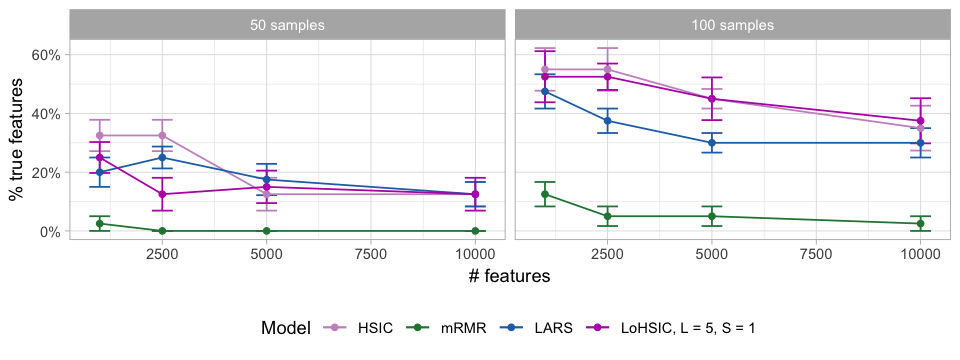

In [59]:
# Feature selection measures
ya_features <- read_tsv('../results/others_benchmark_2noise/yamada_additive_feature_selection.tsv', 
                        col_types = 'ciiiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup %>%
    filter(! is.na(model))  %>%
    filter(samples_txt != '200 samples') %>%
    filter(samples_txt != '300 samples')
ya_features_lhsic <- read_tsv('../results/lhl_benchmark_additive_scale_2noise/yamada_additive_feature_selection.tsv', 
                        col_types = 'ciiiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup
ya_features_all <- bind_rows(ya_features, ya_features_lhsic)

# Regression measures
ya_prediction <- read_tsv('../results/others_benchmark_2noise/yamada_additive_prediction.tsv', 
                       col_types = 'ciiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(mse)),
              sem = sd(mse) / sqrt(ended), mse = mean(mse) ) %>%
    ungroup %>%
    filter(! is.na(model))
ya_prediction_lhsic <- read_tsv('../results/lhl_benchmark_additive_scale_2noise/yamada_additive_prediction_lhsic.tsv', 
                       col_types = 'ciiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(mse)),
              sem = sd(mse) / sqrt(ended), mse = mean(mse) ) %>%
    ungroup
ya_prediction_all <- bind_rows(ya_prediction, ya_prediction_lhsic)

options(repr.plot.width=8, repr.plot.height=3.)
padd_2noise <- ggplot(ya_features_all, aes(x = features, y = tpr, color = model)) +
    geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 500) +
    geom_point() +
    geom_line() +
    theme_light() +
    theme(legend.position = 'bottom') +
    labs(x = '# features', y = '% true features', color = 'Model') +
    facet_grid(. ~ samples_txt) + 
    scale_y_continuous(labels = scales::percent) +
    scale_color_manual(values = palette)
padd_2noise
save_plot('./imgs/lhsic_additive_2noise.pdf', padd_2noise, base_height = 3.0, base_width = 6.0)

# additive + 3noise

In [71]:
library(tidyverse)
library(cowplot)

palette <- c('HSIC' = '#c994c7', 
#              'HSIC Lasso, B = 50' = '#df65b0',
#              'HSIC Lasso, B = 20' = '#e7298a', 'HSIC Lasso, B = 10' = '#ce1256',
#              'HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443',
             'LoHSIC, L = 1, S = 1' = '#abaf1c',
#              'LoHSIC, L = 1, S = 10' = '#1bd145',
             'LoHSIC, L = 5, S = 1' = '#b70eb7'
#              'LoHSIC, L = 5, S = 10' = '#b5c61b'
            )
methods <- c('HSIC', 
#              'HSIC Lasso, B = 50',
#              'HSIC Lasso, B = 40','HSIC Lasso, B = 30',
#              'HSIC Lasso, B = 20','HSIC Lasso, B = 10',
#              'HSIC Lasso, B = 5', 
             'mRMR', 'LARS',
             'LoHSIC, L = 1, S = 1',
#              'LoHSIC, L = 1, S = 10',
             'LoHSIC, L = 5, S = 1'
#              'LoHSIC, L = 5, S = 10'
             
            )
samples_ord <-  c('50 samples', '100 samples', '200 samples', '300 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')

prepare_df <- function(x) {
    mutate(x,
           model = gsub('HSIC_lasso', 'HSIC', model),
           model = gsub('-B=0', '', model),
           model = gsub('-B=', ', B = ', model),
           model = gsub('-M=3', '', model),
           model = gsub('localized_', 'Lo', model),
           model = gsub('-K=', ', L = ', model),
           model = gsub('-S=', ', S = ', model),
           model = factor(model, levels = methods),
           samples_txt = factor(paste(samples, 'samples'), levels=samples_ord),
           causal_txt = paste(causal, 'causal'),
           features_txt = factor(paste(features, 'features'), levels = feats)) %>%
    group_by(model, samples, features, causal, samples_txt, features_txt, causal_txt) 
}

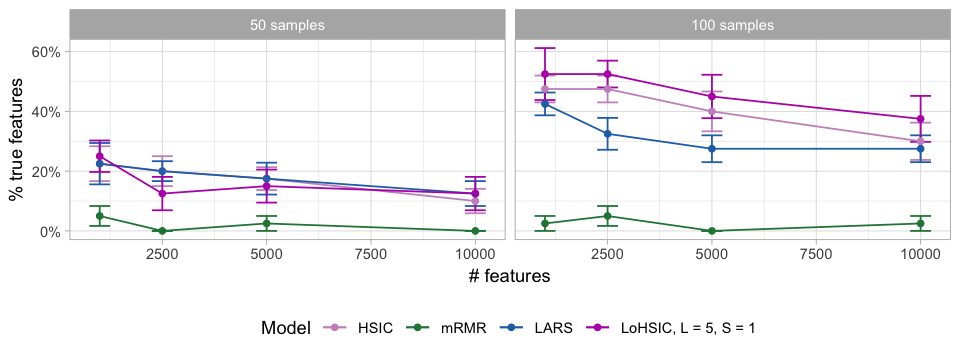

In [73]:
# Feature selection measures
ya_features <- read_tsv('../results/others_benchmark_3noise/yamada_additive_feature_selection.tsv', 
                        col_types = 'ciiiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup %>%
    filter(! is.na(model))  %>%
    filter(samples_txt != '200 samples') %>%
    filter(samples_txt != '300 samples')
ya_features_lhsic <- read_tsv('../results/lhl_benchmark_additive_scale_2noise/yamada_additive_feature_selection.tsv', 
                        col_types = 'ciiiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup
ya_features_all <- bind_rows(ya_features, ya_features_lhsic)

# Regression measures
ya_prediction <- read_tsv('../results/others_benchmark_3noise/yamada_additive_prediction.tsv', 
                       col_types = 'ciiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(mse)),
              sem = sd(mse) / sqrt(ended), mse = mean(mse) ) %>%
    ungroup %>%
    filter(! is.na(model))
ya_prediction_lhsic <- read_tsv('../results/lhl_benchmark_additive_scale_2noise/yamada_additive_prediction_lhsic.tsv', 
                       col_types = 'ciiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(mse)),
              sem = sd(mse) / sqrt(ended), mse = mean(mse) ) %>%
    ungroup
ya_prediction_all <- bind_rows(ya_prediction, ya_prediction_lhsic)

options(repr.plot.width=8, repr.plot.height=3.)
padd_2noise <- ggplot(ya_features_all, aes(x = features, y = tpr, color = model)) +
    geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 500) +
    geom_point() +
    geom_line() +
    theme_light() +
    theme(legend.position = 'bottom') +
    labs(x = '# features', y = '% true features', color = 'Model') +
    facet_grid(. ~ samples_txt) + 
    scale_y_continuous(labels = scales::percent) +
    scale_color_manual(values = palette)
padd_2noise
save_plot('./imgs/lhsic_additive_2noise.pdf', padd_2noise, base_height = 3.0, base_width = 6.0)

# Non-additive + 1noise

In [49]:
library(tidyverse)
library(cowplot)
library(latex2exp)
library(tikzDevice)

palette <- c('HSIC' = '#c994c7', 
#              'HSIC Lasso, B = 50' = '#df65b0',
#              'HSIC Lasso, B = 20' = '#e7298a', 'HSIC Lasso, B = 10' = '#ce1256',
#              'HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443',
#              'LoHSIC, L = 5, S = 10' = '#abaf1c',
#              'LoHSIC, L = 5, S = 100' = '#1bd145',
#              'LoHSIC, L = 5, S = 1' = '#b70eb7'
             
             'LoHSIC, L = 1, S = 1' = '#abaf1c',
#              'LoHSIC, L = 1, S = 10' = '#1bd145',
             'LoHSIC, L = 5, S = 1' = '#b70eb7'
#              'LoHSIC, L = 5, S = 10' = '#b5c61b'
            )
methods <- c('HSIC', 
#              'HSIC Lasso, B = 50',
#              'HSIC Lasso, B = 40','HSIC Lasso, B = 30',
#              'HSIC Lasso, B = 20','HSIC Lasso, B = 10',
#              'HSIC Lasso, B = 5', 
             'mRMR', 'LARS',
             'LoHSIC, L = 1, S = 1',
#              'LoHSIC, L = 1, S = 10',
             'LoHSIC, L = 5, S = 1'
#              'LoHSIC, L = 5, S = 10'
            )
samples_fct <-  c('50 samples', '100 samples', '200 samples', '300 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')

prepare_df <- function(x) {
    mutate(x,
           model = gsub('HSIC_lasso', 'HSIC', model),
           model = gsub('-B=0', '', model),
           model = gsub('-B=', ', B = ', model),
           model = gsub('-S=', ", S = ", model),
           model = gsub('-M=3', '', model),
           model = gsub('localized_', 'Lo', model),
           model = gsub('-K=', ', L = ', model),
           model = factor(model, levels = methods),
           samples_txt = factor(paste(samples, 'samples'), levels = samples_fct),
           causal_txt = paste(causal, 'causal'),
           features_txt = factor(paste(features, 'features'), levels = feats)) %>%
    group_by(model, samples, features, causal, samples_txt, features_txt, causal_txt) 
}

## Non-additive model

The outcome is generated as

$$y = x_1  exp(2x_2) + x_3^2 + \varepsilon$$

where $\varepsilon ~ N(0,1)$. The script is available [here](../scripts/templates/analysis/yamada_nonadditive.py).

In [50]:
# Feature selection measures
yn_features <- read_tsv('../results/others_benchmark/yamada_nonadditive_feature_selection.tsv', 
                        col_types = 'ciiiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup %>%
    filter(! is.na(model)) %>%
    filter(samples_txt != '200 samples') %>%
    filter(samples_txt != '300 samples')
yn_features_lhsic <- read_tsv('../results/lhl_benchmark_nonadditive_scale/yamada_nonadditive_feature_selection.tsv', 
                        col_types = 'ciiiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup %>%
    filter(! is.na(model))
    
yn_features_all <- bind_rows(yn_features, yn_features_lhsic)

# Regression measures
yn_prediction <- read_tsv('../results/others_benchmark/yamada_nonadditive_prediction.tsv', 
                       col_types = 'ciiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(mse)),
              sem = sd(mse) / sqrt(ended), mse = mean(mse) ) %>%
    ungroup %>%
    filter(! is.na(model))
yn_prediction_lhsic <- read_tsv('../results/lhl_benchmark_nonadditive_scale/yamada_nonadditive_prediction.tsv', 
                       col_types = 'ciiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(mse)),
              sem = sd(mse) / sqrt(ended), mse = mean(mse) ) %>%
    ungroup %>%
    filter(! is.na(model))
yn_prediction_all <- bind_rows(yn_prediction, yn_prediction_lhsic)

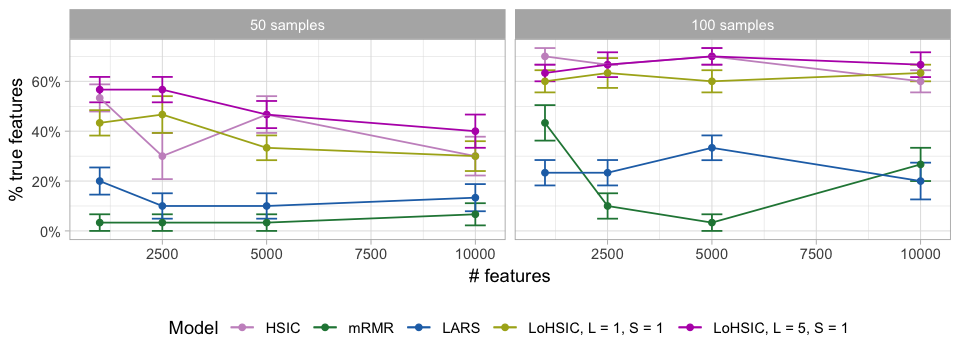

In [51]:
options(repr.plot.width=8.0, repr.plot.height=3.)
pnonad <- ggplot(yn_features_all, aes(x = features, y = tpr, color = model)) +
    geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 500) +
    geom_point() +
    geom_line() +
    theme_light() +
    theme(legend.position = 'bottom') +
    labs(x = '# features', y = '% true features', color = 'Model') +
    facet_grid(. ~ samples_txt) + 
    scale_y_continuous(labels = scales::percent) +
    scale_color_manual(values = palette)

pnonad
save_plot('./imgs/lhsic_non_additive.pdf', pnonad, base_height = 3., base_width = 6.0 )

In [371]:
# options(repr.plot.width=10, repr.plot.height=4)
# yn_prediction_all %>%
#     ggplot(aes(x = samples, y = mse, color = model)) +
#         geom_errorbar(aes(ymin = mse - sem, ymax = mse + sem), width = 500) +
#         geom_point() +
#         geom_line() +
#         theme_linedraw() +
#         theme(legend.position = 'bottom') +
#         labs(x = '# samples', y = 'MSE', color = 'Model') +
#         facet_grid(. ~ features_txt) +
#         scale_color_manual(values = palette)

In [106]:
yn_features_all

model,samples,features,causal,samples_txt,features_txt,causal_txt,n,ended,sem,tpr,selected
HSIC Lasso,100,1000,3,100 samples,1000 features,3 causal,10,10,0.03333333,0.6333333,50.0
HSIC Lasso,100,2500,3,100 samples,2500 features,3 causal,10,10,0.04969040,0.6666667,50.0
HSIC Lasso,100,5000,3,100 samples,5000 features,3 causal,10,10,0.03333333,0.6333333,50.0
HSIC Lasso,100,10000,3,100 samples,10000 features,3 causal,10,10,0.06666667,0.6000000,50.0
HSIC Lasso,1000,1000,3,1000 samples,1000 features,3 causal,10,10,0.05091751,0.9000000,50.0
HSIC Lasso,1000,2500,3,1000 samples,2500 features,3 causal,10,10,0.04444444,0.9333333,50.0
HSIC Lasso,10000,2500,3,10000 samples,2500 features,3 causal,10,0,NaN,NaN,0.0
HSIC Lasso,10000,5000,3,10000 samples,5000 features,3 causal,10,0,NaN,NaN,0.0
HSIC Lasso,10000,10000,3,10000 samples,10000 features,3 causal,10,0,NaN,NaN,0.0
mRMR,100,1000,3,100 samples,1000 features,3 causal,10,10,0.09686442,0.4000000,3.0


# In-house generated data (outdated)

For different combinations we generated synthetic data of varying numbers of samples (100, 1000, 10000) and numbers of features (1000, 2500, 5000, 10000). Applying the above methods, we tried to recover the original causal features. For each experimental condition, we generated 10 replicates. 

In [8]:
# Feature selection measures
features <- read_tsv('../results/benchmark/feature_selection.tsv', col_types = 'ciiiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup

# Regression measures
prediction <- read_tsv('../results/benchmark/prediction.tsv', col_types = 'ciiiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(mse)),
              sem = sd(mse) / sqrt(ended), mse = mean(mse) ) %>%
    ungroup

Let's start by checking which processes were able to perform a feature selection, and which ones, because of computational issues of lack of information, ended up selecting no features.

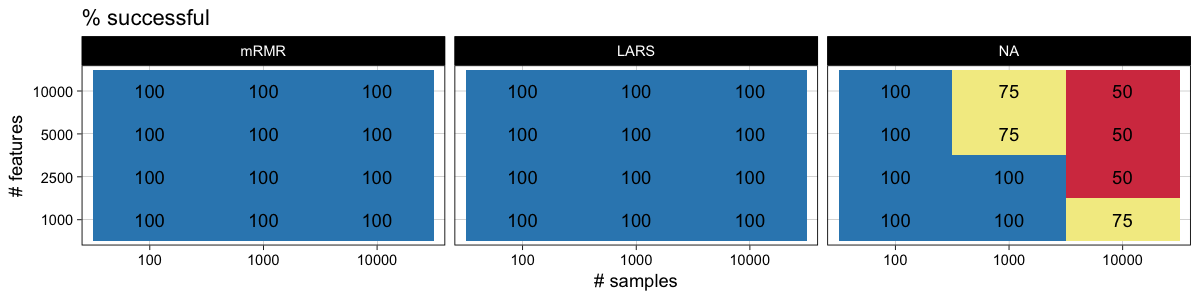

In [9]:
options(repr.plot.width=10, repr.plot.height=2.5)
features %>%
    group_by(model, samples, features) %>%
    summarize(ended = 100 * sum(ended)/sum(n),
              ended_txt = format(round(ended, 1), nsmall = 0)) %>%
    ggplot(aes(x = factor(samples), y = factor(features), fill = ended, label = ended_txt)) +
        geom_tile() +
        geom_text() +
        theme_linedraw() +
        facet_grid(. ~ model) +
        theme(legend.position = 'none') +
        labs(x = '# samples', y = '# features', title = '% successful') + 
        scale_fill_distiller(palette = "Spectral", direction = 1)

Computational resources were not tightly controlled, but we placed a a hard limit of 50GBs on memory consumption. When that memory was exceeded, jobs were killed. Above plot shows which jobs went over the limit. By using blocks, we are able to keep running HSIC Lasso in high dimensions.

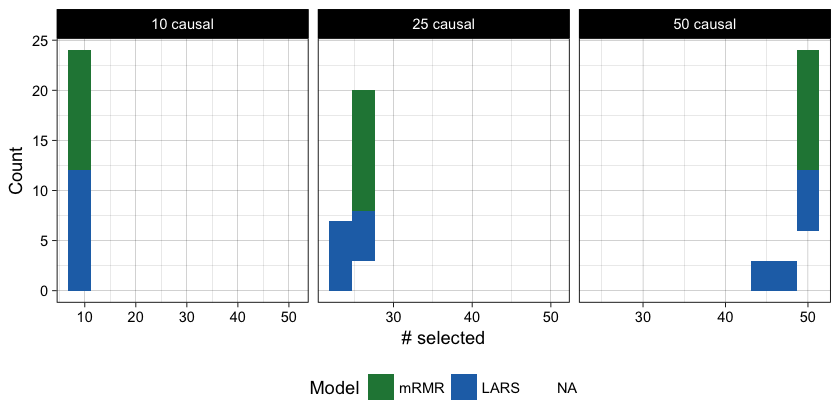

In [10]:
options(repr.plot.width=7, repr.plot.height=3.5)
ggplot(features, aes(selected, fill = model)) + 
    geom_histogram(bins = 10) + 
    facet_grid(. ~ causal_txt, scales = 'free') +
    labs(x = '# selected', y = 'Count', fill = 'Model') +
    theme_linedraw() +
    theme(legend.position = 'bottom') +
    scale_fill_manual(values = palette)

As a sanity check, we plot the number of features selected by each method in each setting. As we see, everything works as expected i.e. HSIC lasso selects 50 features, mRMR selects the number of true causal features and Lasso selects as many features as it wants.

# Feature selection

Warning message:
“Removed 18 rows containing missing values (geom_errorbar).”Warning message:
“Removed 36 rows containing missing values (geom_point).”

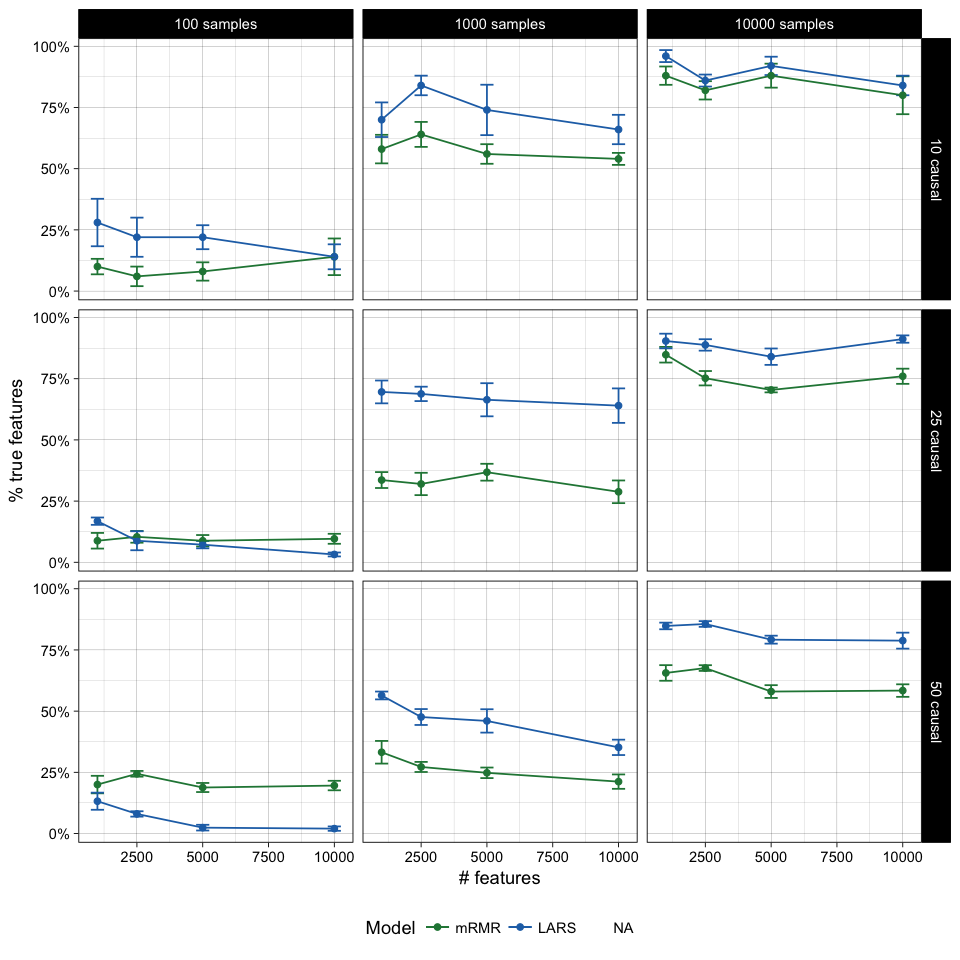

In [11]:
options(repr.plot.width=8, repr.plot.height=8)
ggplot(features, aes(x = features, y = tpr, color = model)) +
    geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 500) +
    geom_point() +
    geom_line() +
    theme_linedraw() +
    theme(legend.position = 'bottom') +
    labs(x = '# features', y = '% true features', color = 'Model') +
    facet_grid(causal_txt ~ samples_txt) + 
    scale_y_continuous(labels = scales::percent) +
    scale_color_manual(values = palette)

Vanilla HSIC Lasso outperforms mRMR in all the settings where is can run. However, it stops working at ~ samples > 1000. Regarding the block versions, they perform worse than mRMR in most settings, specially for smaller block sizes. However, it is not clear if these are the best experimental settings for block HSIC lasso i.e. pick 50 features but use only the top 4.

Lasso seems to select most of the features. However, it does so by selecting a large number of features, some of them being the true features. Maybe something like a F1 score would be better at showing the quality of each method.

# Prediction accuracy

We fitted a kernelized SVR to the features selected by mRMR and HSIC lasso. Then we measured the accuracy of the prediction as mean squared error (MSE) w.r.t. the output vector.

Warning message:
“Removed 18 rows containing missing values (geom_errorbar).”Warning message:
“Removed 36 rows containing missing values (geom_point).”

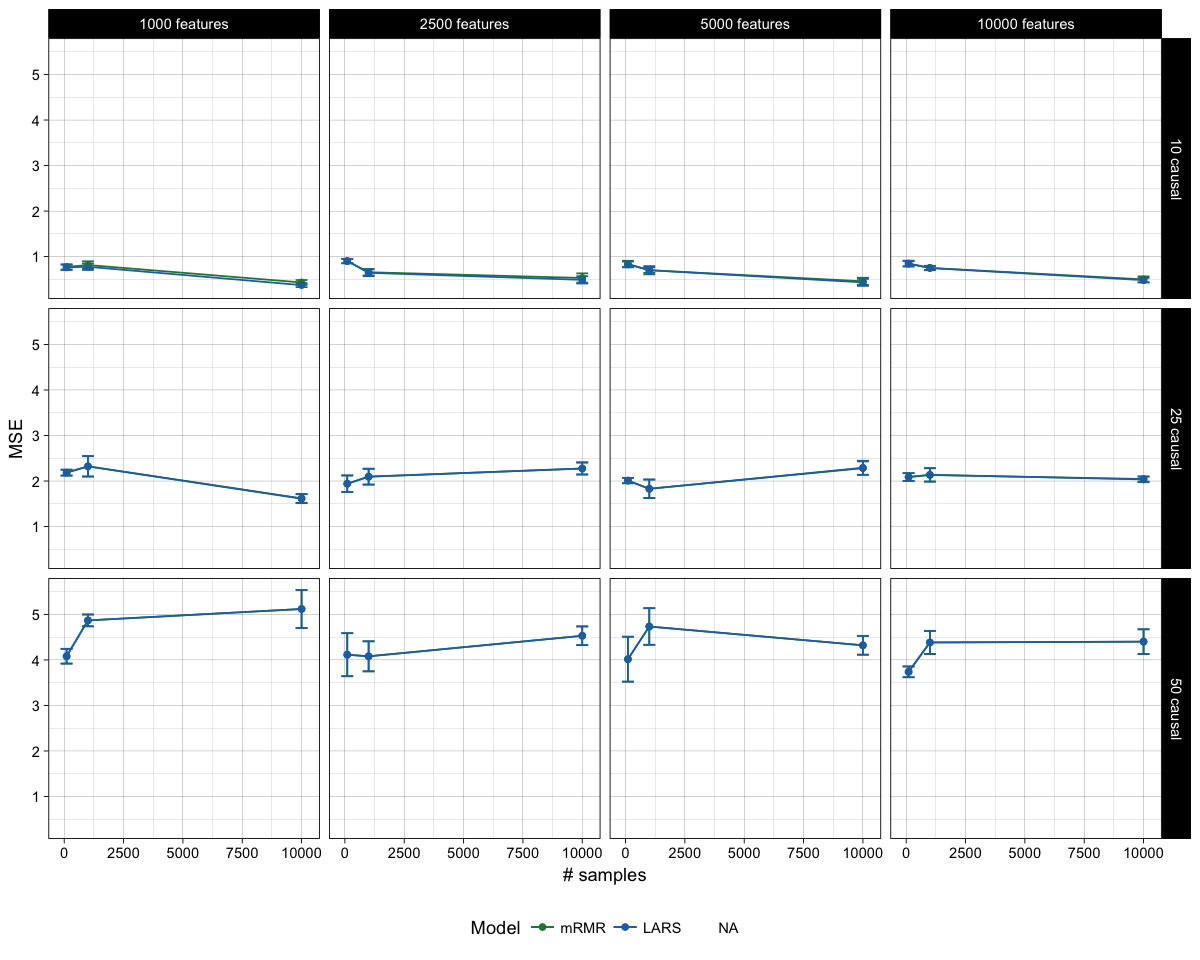

In [12]:
options(repr.plot.width=10, repr.plot.height=8)
prediction %>%
    ggplot(aes(x = samples, y = mse, color = model)) +
        geom_errorbar(aes(ymin = mse - sem, ymax = mse + sem), width = 500) +
        geom_point() +
        geom_line() +
        theme_linedraw() +
        theme(legend.position = 'bottom') +
        labs(x = '# samples', y = 'MSE', color = 'Model') +
        facet_grid(causal_txt ~ features_txt) +
        scale_color_manual(values = palette)

If we look at the accuracy of the classifier, all versions of HSIC Lasso remain very competitive with mRMR. This means that out of the 50 features, HSIC lasso is selecting all the true features. Interestingly, Lasso is very competitive as well, meaning that the behavior of the features can be well approximated by a line.